In [1]:
!pip install -qq timm
import timm

In [2]:
from fastai.vision.all import *
set_seed(42)

from fastcore.parallel import *
from fastai.data.core import *
import torch
import time

In [4]:
import pandas as pd

In [6]:
df = pd.read_csv('/home/webadmin/Desktop/isic/train-metadata.csv')

df['isic_id'] = [name + '.jpg' for name in df['isic_id']]
df = df.set_index('isic_id')

#Calculate weights for the umbalanced data:
# Step 1: Count the number of samples for each class
class_counts = df['target'].value_counts().sort_index()

# Step 2: Calculate class weights
class_weights = class_counts.sum() / (len(class_counts) * class_counts)

# Step 3: Normalize the class weights
class_weights = class_weights / class_weights.sum()

# Step 4: Convert to PyTorch tensor
class_weights = torch.tensor(class_weights.values, dtype=torch.float32)

# Print the class weights
print(class_weights)

/tmp/ipykernel_62421/3468682081.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/webadmin/Desktop/isic/train-metadata.csv')


tensor([9.7991e-04, 9.9902e-01])


In [7]:
#later we can try to include diagnosis as well
#def get_diagnosis(p): return df.loc[p.name, 'iddx_full']

def get_target(p): return df.loc[p.name, 'target']

In [8]:
from pathlib import Path
images_path= Path('/home/webadmin/Desktop/isic/image')

%timeit
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [get_target],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(125, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(images_path,num_workers=4)

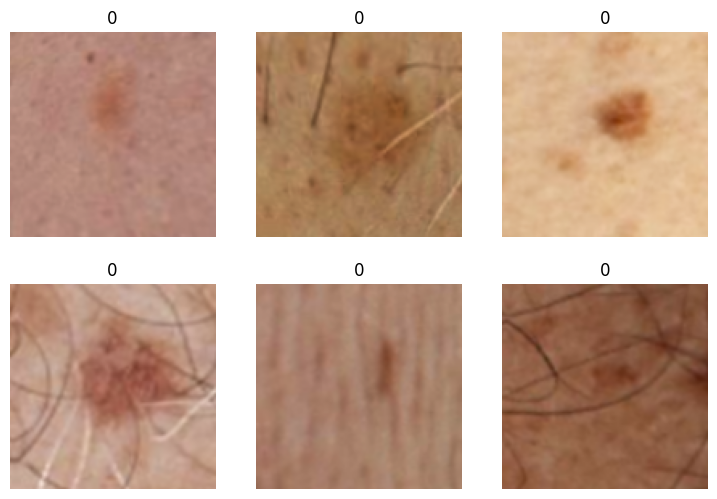

In [10]:
dls.show_batch(max_n=6)

In [11]:
def target_err(inp,target): return error_rate(inp,target)
#def target_loss(inp,target): return F.cross_entropy(inp,target,weight=class_weights)
def target_loss(inp, target):
    device = inp.device  # Get the device from input tensor
    current_class_weights = class_weights.to(device)  # Move class weights to the same device
    return F.cross_entropy(inp, target, weight=current_class_weights)

In [12]:
arch = 'convnext_small_in22k'
#learn = vision_learner(dls, arch, loss_func=target_loss, metrics=target_err, n_out=7).to_fp16()
lr = 0.01

# Custom loss function with class weights on the correct device
def target_loss(inp, target):
    device = inp.device  # Get the device from input tensor
    current_class_weights = class_weights.to(device)  # Move class weights to the same device
    return F.cross_entropy(inp, target, weight=current_class_weights)

# Create the learner
learn = vision_learner(dls, arch, loss_func=target_loss, metrics=target_err,n_out=2).to_fp16()

/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.10/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

In [13]:
model_path = Path('/home/webadmin/Desktop/isic/convnext_small_in22k_model.pkl')

if not model_path.exists():
    # Model does not exist, so train and save the model
    learn.fit_one_cycle(4, lr_max=1e-4)
    learn.save(model_path.stem)
else:
    # Model exists, so load, fine-tune, and save it
    learn.load(model_path.stem)
    learn.fine_tune(4, lr_max=1e-4)
    learn.save(model_path.stem)

epoch,train_loss,valid_loss,target_err,time
0,0.245072,0.169715,0.006745,12:56
1,0.329694,0.155724,0.012180,12:29
2,0.319973,0.164008,0.005560,12:30
3,0.142292,0.165010,0.004339,12:29


In [16]:
from pathlib import Path

save_dir = Path("/home/webadmin/Desktop/isic/models")
save_dir.mkdir(parents=True, exist_ok=True)  # make the folder if missing
learn.export(save_dir / "my_model.pkl")      # export the whole Learner
print("Saved to:", save_dir / "my_model.pkl")


Saved to: /home/webadmin/Desktop/isic/models/my_model.pkl


In [17]:
#Save the trained model, i think it takes long time
learn.export('/home/webadmin/Desktop/isic/models/my_model.pkl')

**TEST PART**

In [18]:
ROOT_DIR = "/home/webadmin/Desktop/isic/"
TEST_HDF = f'{ROOT_DIR}/test-image.hdf5'


In [19]:
import h5py
import numpy as np
from PIL import Image
from io import BytesIO
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class ISICDataset(Dataset):
    def __init__(self, file_hdf, transforms=None, target_size=(125,125)):
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.image_ids = list(self.fp_hdf.keys())
        self.transforms = transforms
        self.target_size = target_size

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        img_id = self.image_ids[index]
        img = Image.open(BytesIO(self.fp_hdf[img_id][()]))

        # Resize the image
        img = img.resize(self.target_size, Image.LANCZOS)

        # Apply transformations if provided
        if self.transforms:
            img = self.transforms(img)

        # Return image and a dummy target
        return img, 0  # Dummy target (could be any value between 0 and 1)

# Define your configuration
CONFIG = {
    'valid_batch_size': 32
}


data_transforms = T.Compose([
    T.Resize((125, 125)),  # Resize images to a fixed size
    T.ToTensor(),  # Convert PIL Image to tensor
])


In [20]:
from torch.utils.data import DataLoader

# Define transformations directly
data_transforms = T.Compose([
    T.Resize((125, 125)),  # Resize images to a fixed size
    T.ToTensor(),  # Convert PIL Image to tensor
])

# Create the dataset and DataLoader
test_dataset = ISICDataset(file_hdf=TEST_HDF, transforms=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'],
                        num_workers=4, shuffle=False, pin_memory=True)

In [21]:
# Set the model to evaluation mode
learn.model.eval()

# Run predictions on the test DataLoader
preds, _ = learn.get_preds(dl=test_loader)

In [22]:
import torch.nn.functional as F

# Initialize lists to collect probabilities and IDs
all_probs_class_1 = []
all_isic_ids = []


# Iterate over DataLoader
with torch.no_grad():
    for imgs, _ in test_loader:
        # Forward pass to get logits
        imgs = imgs.cuda()
        logits = learn.model(imgs)  # Get model outputs directly

        # Apply softmax to get probabilities
        probabilities = F.softmax(logits, dim=1)

        # Extract the probabilities for class ID 1
        prob_class_1 = probabilities[:, 1].detach().cpu().numpy()

        # Collect the probabilities
        all_probs_class_1.extend(prob_class_1)

        # Collect IDs
        batch_ids = [test_dataset.image_ids[i] for i in range(len(prob_class_1))]
        all_isic_ids.extend(batch_ids)

# Convert lists to arrays or DataFrame if needed
import numpy as np
all_probs_class_1 = np.array(all_probs_class_1)
all_isic_ids = np.array(all_isic_ids)

In [23]:
# Create DataFrame
submission_df = pd.DataFrame({
    'isic_id': all_isic_ids,
    'prob_class_1': all_probs_class_1
})

# Save DataFrame to CSV
submission_df.to_csv('submission.csv', index=False)

In [24]:
submission_df

,isic_id,prob_class_1
0,ISIC_0015657,0.054874
1,ISIC_0015729,0.002609
2,ISIC_0015740,0.001730
